In [1]:
import numpy as np

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
import qiskit_aer.noise as noise

In [2]:
class ClassicalOracle:
    def __init__(self, secret: np.array):
        self.n = len(secret)
        self.count = 0
        self.secret = secret

    def complexity(self) -> int:
        return self.n

    def number_of_queries(self) -> int:
        return self.count

    def query(self, inp: np.array) -> bool:
        self.count += 1
        product = np.dot(self.secret, inp)
        return product % 2


def classical_bv_algorithm(oracle: ClassicalOracle) -> np.array:
    n = oracle.complexity()
    secret = np.zeros(n, dtype=np.byte)

    for i in range(n):
        inp = np.zeros(n, dtype=np.byte)
        inp[i] = 1

        if oracle.query(inp):
            secret[i] = 1

    return secret

In [3]:
secret_str = list("00101110100")

secret = np.array(secret_str, dtype=np.byte)
oracle = ClassicalOracle(secret)

solution = classical_bv_algorithm(oracle)

print("secret string:".ljust(20, " "), secret)
print("classical solution:".ljust(20, " "), solution)
print("match:".ljust(20, " "), np.array_equal(solution, secret))
print("# of queries:".ljust(20, " "), oracle.number_of_queries())

secret string:       [0 0 1 0 1 1 1 0 1 0 0]
classical solution:  [0 0 1 0 1 1 1 0 1 0 0]
match:               True
# of queries:        11


In [14]:
n = len(secret)

query_reg = QuantumRegister(n, "query")
auxiliary_reg = QuantumRegister(1, "auxiliary")
oracle = QuantumCircuit(query_reg, auxiliary_reg, name="oracle")

for i in range(n):
    if secret[n - i - 1]:
        oracle.cx(query_reg[i], auxiliary_reg[0])

oracle.draw()

query_0: ─────────────────────────
                                    
  query_1: ─────────────────────────
                                    
  query_2: ──■──────────────────────
             │                      
  query_3: ──┼──────────────────────
             │                      
  query_4: ──┼────■─────────────────
             │    │                 
  query_5: ──┼────┼────■────────────
             │    │    │            
  query_6: ──┼────┼────┼────■───────
             │    │    │    │       
  query_7: ──┼────┼────┼────┼───────
             │    │    │    │       
  query_8: ──┼────┼────┼────┼────■──
             │    │    │    │    │  
  query_9: ──┼────┼────┼────┼────┼──
             │    │    │    │    │  
 query_10: ──┼────┼────┼────┼────┼──
           ┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐┌─┴─┐
auxiliary: ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├
           └───┘└───┘└───┘└───┘└───┘

In [15]:
qr = QuantumRegister(n, "q")
cr = ClassicalRegister(n, "c")
aux = QuantumRegister(1, "aux")
qc = QuantumCircuit(qr, aux, cr)

qc.h(qr)
qc.x(aux)
qc.h(aux)

qc.append(oracle, [*qr, aux])

qc.h(qr)
qc.barrier()

qc.measure(qr, cr)

qc.draw()

┌───┐     ┌──────────┐┌───┐ ░ ┌─┐                              
 q_0: ┤ H ├─────┤0         ├┤ H ├─░─┤M├──────────────────────────────
      ├───┤     │          │├───┤ ░ └╥┘┌─┐                           
 q_1: ┤ H ├─────┤1         ├┤ H ├─░──╫─┤M├───────────────────────────
      ├───┤     │          │├───┤ ░  ║ └╥┘┌─┐                        
 q_2: ┤ H ├─────┤2         ├┤ H ├─░──╫──╫─┤M├────────────────────────
      ├───┤     │          │├───┤ ░  ║  ║ └╥┘┌─┐                     
 q_3: ┤ H ├─────┤3         ├┤ H ├─░──╫──╫──╫─┤M├─────────────────────
      ├───┤     │          │├───┤ ░  ║  ║  ║ └╥┘┌─┐                  
 q_4: ┤ H ├─────┤4         ├┤ H ├─░──╫──╫──╫──╫─┤M├──────────────────
      ├───┤     │          │├───┤ ░  ║  ║  ║  ║ └╥┘┌─┐               
 q_5: ┤ H ├─────┤5         ├┤ H ├─░──╫──╫──╫──╫──╫─┤M├───────────────
      ├───┤     │   oracle │├───┤ ░  ║  ║  ║  ║  ║ └╥┘┌─┐            
 q_6: ┤ H ├─────┤6         ├┤ H ├─░──╫──╫──╫──╫──╫──╫─┤M├────────────
      ├───┤     │          │├───┤ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐         
 q_7: ┤ H ├─────┤7         ├┤ H ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├─────────
      ├───┤     │          │├───┤ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      
 q_8: ┤ H ├─────┤8         ├┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────
      ├───┤     │          │├───┤ ░  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   
 q_9: ┤ H ├─────┤9         ├┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───
      ├───┤     │          │├───┤ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
q_10: ┤ H ├─────┤10        ├┤ H ├─░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├
      ├───┤┌───┐│          │└───┘ ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘
 aux: ┤ X ├┤ H ├┤11        ├──────░──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─
      └───┘└───┘└──────────┘      ░  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ 
c: 11/═══════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩══╩══╩══╩═
                                     0  1  2  3  4  5  6  7  8  9  10

In [16]:
job = execute(qc, Aer.get_backend("qasm_simulator"), shots=1000)
counts = job.result().get_counts()

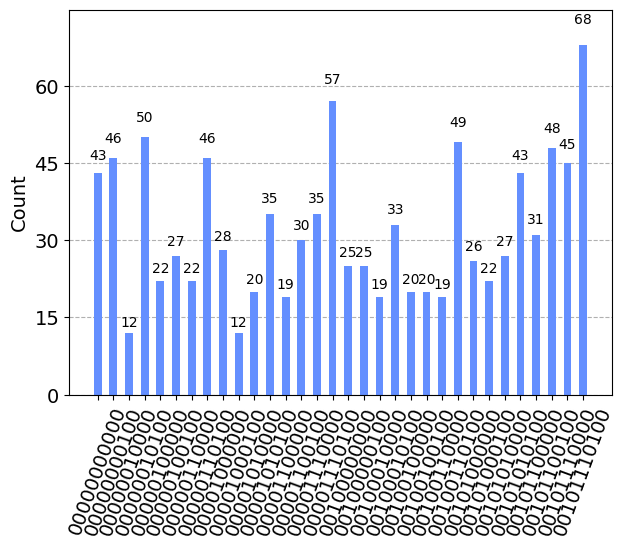

In [25]:
plot_histogram(counts)

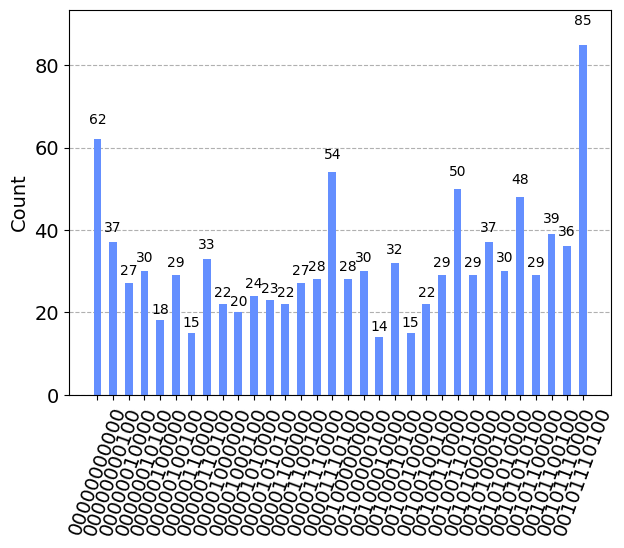

In [31]:
# Error probabilities
prob_1 = 0.3  # 1-qubit gate
prob_2 = 0.3  # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ["h", "z", "x"])
noise_model.add_all_qubit_quantum_error(error_2, ["cx"])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# transpiled_qc = transpile(qc, qasm_simulator)
# Execute circuit and show results
ex = execute(
    qc,
    Aer.get_backend("qasm_simulator"),
    basis_gates=basis_gates,
    noise_model=noise_model,
)
counts = ex.result().get_counts(qc)

plot_histogram(counts, target_string=)

In [55]:
d1 = dict(list(counts.items()))
d2 = {"".join(secret_str) : counts["".join(secret_str)]}

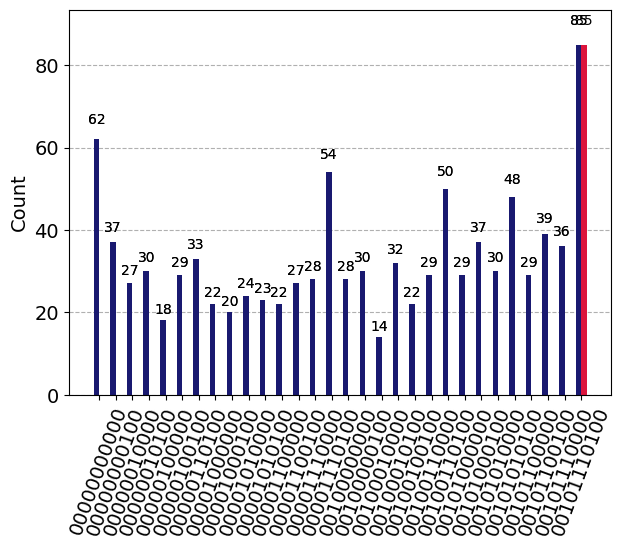

In [53]:
plot_histogram([d1, d2], color=['midnightblue','crimson'])